## Graph Convolutional Networks



### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/gcn/base_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/gcn/base_nb.ipynb)

### 筆者の環境

In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G103


In [3]:
!python -V

Python 3.8.5


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

print(nx.__version__)

2.5


In [2]:
# torchの読み込み
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print(torch.__version__)

1.4.0


## Graph Convolutional Networks 

## 参照論文
  - [1][SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907.pdf)
  - [2][Neural Graph Collaborative Filtering](https://arxiv.org/pdf/1905.08108.pdf)
  - [3][LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation](https://arxiv.org/pdf/2002.02126.pdf)
  - [4][UltraGCN: Ultra Simplification of Graph Convolutional Networks for Recommendation](https://arxiv.org/abs/2110.15114)


![](./1.png)

In [133]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()

print(loss)

# 入力のサイズはN x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)

print(input)
# ターゲットの各要素は0 <=値<Cである必要があります
target = torch.tensor([1, 0, 4])
print(target)
output = loss(m(input), target)
print(output)
output.backward()

NLLLoss()
tensor([[ 0.1064,  0.4910,  0.7079,  1.4534,  0.4364],
        [ 0.1860,  0.4660,  0.4329, -1.0039,  0.3334],
        [-0.1303,  0.4550,  0.3146,  0.0974,  0.7234]], requires_grad=True)
tensor([1, 0, 4])
tensor(1.5711, grad_fn=<NllLossBackward>)


In [5]:
G = nx.karate_club_graph()

pos = nx.spring_layout(G)
color = []
for node in G.nodes:
  print(G.node)
  if G.node[node]['club'] == 'Mr. Hi':
    color.append('r')
  elif G.node[node]['club'] == 'Officer':
    color.append('b')

plt.figure(figsize=(5, 5))
#nx.draw(G, pos=pos, node_size=200, node_color=color, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=200, node_color=color, with_labels=True)

AttributeError: 'Graph' object has no attribute 'node'

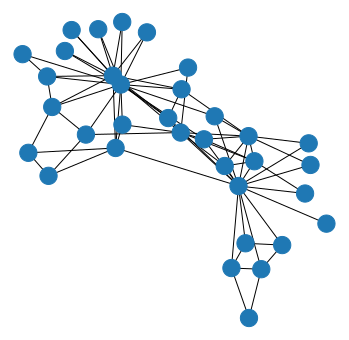

In [6]:
# networkx, matplotlib の import
import networkx as nx
import matplotlib.pyplot as plt

# グラフの構築
G = nx.karate_club_graph()

# レイアウトの取得
pos = nx.spring_layout(G)

# 可視化
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos)
plt.axis('off')
plt.show()

レコメンドにおけるグラフは、通常2部グラフとして表現されます。

In [24]:
B = nx.Graph()
B.add_nodes_from([1,2,3,4,5], bipartite=0)
B.add_nodes_from(['a', 'b', 'c', 'd', 'e', 'f', 'g'], bipartite=1)
B.add_edges_from([(1,'a'), (1,'b'), (2, 'a'), (2, 'c'), (3, 'g'), (4, 'd'), (5, 'e'), (5, 'f')])

node_color = []
for i in range(5):
  node_color.append('red')
for i in range(7):
  node_color.append('blue')
print(node_color)
print(nx.bipartite.sets(B))
top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B, top)
nx.draw(B, pos=pos, with_labels=True, node_color=node_color)
plt.show()

['red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

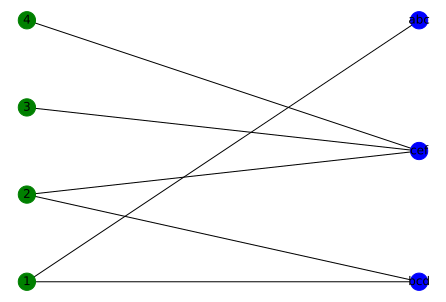

In [34]:
B = nx.Graph()
B.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(['abc','bcd','cef'], bipartite=1)
B.add_edges_from([(1,'abc'), (1,'bcd'), (2,'bcd'), (2,'cef'), (3,'cef'), (4,'cef')])

top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B, top)
nx.draw(B, pos=pos, with_labels=True, node_color=['green','green','green','green','blue','blue','blue'])
plt.show()

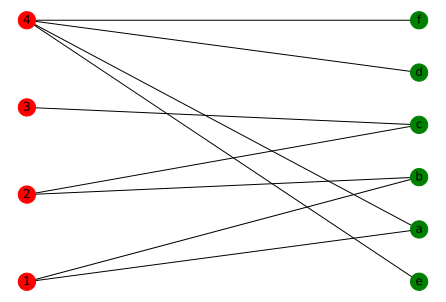

In [66]:
B = None
B = nx.Graph()
B.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(['a','b','c', 'd', 'e','f'], bipartite=1)
B.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a'), (4, 'd'),(4, 'e'), (4,'f')])

node_color = []
for i in range(4):
  node_color.append('red')
for i in range(6):
  node_color.append('green')


top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B, top)
nx.draw(B, pos=pos, with_labels=True, node_color=node_color)
# nx.draw(B, pos=pos, with_labels=True, node_color=['green','green','green','green','blue','blue'])
plt.show()

レコメンドにおいて、嗜好行列


|  | item_1 | item_2 | item_3 | item_4 | item_5 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| user_1 | 0 | 1 | 1 | 0 | 0 |
| user_2 | 0 | 0 | 0 | 1 | 0 |
| user_3 | 1 | 0 | 0 | 0 | 1 |
| user_4 | 1 | 1 | 1 | 1 | 0 |
| user_5 | 0 | 0 | 0 | 0 | 1 |
| user_6 | 0 | 0 | 1 | 0 | 0 |



$$
\begin{equation}
\mathbf{R}_{u, i}=\left\{\begin{array}{l}
1 \\
0
\end{array}\right.
\end{equation}
$$

$$
R_{u, i}=\left\{\begin{array}{lr}
1, & \text { if }(u, i) \text { interaction is observed } \\
0, & \text { otherwise }
\end{array}\right.
$$

$$
\boldsymbol{R} \in\{0,1\}^{|\mathcal{U}| \times|\mathcal{I}|}
$$

$$
\mathbf{R}_{u, i}=\left\{\begin{array}{lr}
1, & \text { if }(u, i) \text { interaction is observed } \\
0, & \text { otherwise }
\end{array}\right.
$$

レコメンドにおいて、嗜好行列


|  | item_1 | item_2 | item_3 | item_4 | item_5 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| user_1 | 0 | 1 | 1 | 0 | 0 |
| user_2 | 0 | 0 | 0 | 1 | 0 |
| user_3 | 1 | 0 | 0 | 0 | 1 |
| user_4 | 1 | 1 | 1 | 1 | 0 |
| user_5 | 0 | 0 | 0 | 0 | 1 |
| user_6 | 0 | 0 | 1 | 0 | 0 |




$$
A=\left(\begin{array}{cc}
0 & R \\
R^{T} & 0
\end{array}\right)
$$

$$
\tilde{R}=D_{U}^{-\frac{1}{2}} R D_{I}^{-\frac{1}{2}}
$$

In [100]:
A = nx.adjacency_matrix(B).todense()
A

matrix([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], dtype=int64)

networkxにはグラフラプラシアン$L$を求める関数が酔いされています。
$$
L=D-A
$$

In [101]:
L = nx.laplacian_matrix(B).todense()
L

matrix([[ 2,  0,  0,  0, -1, -1,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0, -1, -1,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  0, -1,  0,  0,  0],
        [ 0,  0,  0,  4, -1,  0,  0, -1, -1, -1],
        [-1,  0,  0, -1,  2,  0,  0,  0,  0,  0],
        [-1, -1,  0,  0,  0,  2,  0,  0,  0,  0],
        [ 0, -1, -1,  0,  0,  0,  2,  0,  0,  0],
        [ 0,  0,  0, -1,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0, -1,  0,  0,  0,  0,  1,  0],
        [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  1]], dtype=int64)

次数行列は以下の様に求める事が出来ます。

$$
D = L + A
$$

In [102]:
D = L + A
D

matrix([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [88]:
import numpy as np
import numpy.linalg as LA

Lambda = np.linalg.eig(L)[0]

In [89]:
U = np.linalg.eig(L)[1]

In [90]:
U @ np.diagflat(Lambda) @ U.T

matrix([[ 2.00000000e+00, -2.46981255e-16, -3.10515502e-16,
          2.42969707e-15, -1.00000000e+00, -1.00000000e+00,
          7.15465014e-16, -8.91935267e-16, -8.43993182e-16,
         -7.99586751e-16],
        [-1.36067373e-16,  2.00000000e+00, -1.70002901e-16,
          1.26461341e-15,  1.83186799e-15, -1.00000000e+00,
         -1.00000000e+00, -3.03656075e-16, -3.87629330e-16,
         -4.08529279e-16],
        [-3.66026653e-16, -2.81025203e-16,  1.00000000e+00,
          2.01227923e-16, -2.68882139e-16,  5.37764278e-17,
         -1.00000000e+00, -1.39667317e-16, -7.70490482e-17,
         -9.55338606e-17],
        [ 2.49214711e-15,  1.27849120e-15,  2.04697370e-16,
          4.00000000e+00, -1.00000000e+00, -1.89084859e-15,
          2.79290480e-16, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00],
        [-1.00000000e+00,  1.88737914e-15, -1.56125113e-16,
         -1.00000000e+00,  2.00000000e+00, -1.86049093e-16,
          1.20563282e-16,  2.36884101e-17,  5.050867

## グラフラプラシアンの正規化

$$
\tilde{L}=I-\tilde{A}
$$

$$
\Delta f=\frac{\partial^{2} f}{\partial x^{2}}+\frac{\partial^{2} f}{\partial y^{2}}+\frac{\partial^{2} f}{\partial z^{2}}
$$

In [121]:
nD = np.diagflat(np.power(np.array(np.sum(D, axis=0))[0] + 1e-15, -1/2))
nA = nD @ A @ nD
nL = np.eye(len(nA)) - nA
nLambda = np.linalg.eig(nL)[0]
nU = np.linalg.eig(nL)[1]
nU @ np.diagflat(nLambda) @ nU.T

matrix([[ 1.00000000e+00,  6.46184495e-17, -5.05238212e-17,
          1.24856722e-15, -5.00000000e-01, -5.00000000e-01,
         -3.61039323e-16, -6.19510098e-16, -6.59214287e-16,
         -7.23905449e-16],
        [ 5.07406617e-17,  1.00000000e+00, -9.19403442e-16,
         -3.03576608e-16,  1.70002901e-16, -5.00000000e-01,
         -5.00000000e-01,  2.04890223e-16,  1.53518028e-17,
          1.89152714e-16],
        [-2.28766658e-17, -9.22872889e-16,  1.00000000e+00,
         -6.41847686e-17, -4.76181594e-16,  1.11022302e-16,
         -7.07106781e-01,  7.66347748e-17, -1.01105375e-16,
          2.25698524e-16],
        [ 1.25528928e-15, -2.48065457e-16, -9.71445147e-17,
          1.00000000e+00, -3.53553391e-01, -4.29344060e-16,
          2.77555756e-17, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01],
        [-5.00000000e-01,  1.70002901e-16, -4.48426019e-16,
         -3.53553391e-01,  1.00000000e+00,  7.73252989e-16,
          4.51028104e-16,  2.60613411e-16,  2.696036

In [125]:
embedding = torch.nn.Embedding(num_embeddings=len(nA), embedding_dim=len(nA))
dir(embedding)

['__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'embedding_dim',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'from_pretrained',
 'h

$$
\Delta h_{\omega}(x)=\lambda_{\omega} h_{\omega}(x)
$$

$$
h_{\omega}(x)=e^{i \omega x}
$$

$$
g(t) * f(t)=\sum_{\tau} g(\tau) f(t-\tau)
$$

$$
F[g(t) * f(t)]=F[g(t)] F[f(t)]
$$

$$
\begin{gathered}
\hat{\mathbf{x}}=\mathbf{U}^{T} \mathbf{x} \\
\mathbf{x}=\mathbf{U} \widehat{\mathbf{x}}
\end{gathered}
$$

$$
\mathcal{H}(\boldsymbol{L})=\operatorname{UDiag}\left(h\left(\lambda_{1}\right), \cdots, h\left(\lambda_{n}\right)\right) U^{T}
$$